In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pylab as pl

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_predict


import random
import sys
from scipy import stats
% matplotlib inline
%load_ext autoreload
%autoreload 2
from regression_functions import *
from reg_plots import *


## Import Data

In [2]:
pod_number = 'cham_1'

In [3]:
df_pod = pd.io.parsers.read_csv(filepath_or_buffer = 'data/cham_1_open_only.csv', parse_dates = [0], index_col = 0)
df_pod = df_pod.rename(columns={'o3_ppb': 'O3_ppb'})

## Import Reference Data

In [4]:
df_ref = pd.DataFrame.from_csv('data/coll_2b.csv', index_col=0, parse_dates=True)
df_ref = df_ref.rename(columns={'c_open': 'O3_ppb'})
df_ref = df_ref.drop('c_close', axis=1)

In [5]:
resamp_time = '1H'
df_all = pd.concat([df_pod.resample(resamp_time), df_ref.resample(resamp_time)], axis=1).dropna()

In [6]:
df_ref.head()

,O3_ppb
date,
2014-07-18 16:39:00,41.183
2014-07-18 17:42:00,49.626
2014-07-18 18:46:00,26.638
2014-07-18 19:49:00,34.020
2014-07-18 20:53:00,30.356


#### Declare whether to process raw or filtered data.

In [7]:
which_data = 0    #1 = filtered, 0 = raw
ref_column, leave_out_pod, pod_ozone = declare_filt_or_raw_dataset(which_data)

#### Call the scaling function and create a dataframe with scaled data.

In [8]:
df_scaled, features, minmax_scale_fit, standard_scale_fit = scale_features_and_create_day_column(df_all, ref_column)
len(df_scaled)

79

#### Declare whether you'd like to use holdout dates from a previous run.

In [9]:
prev_holdout = "true"
chunks = ['7-24 PM']

#### Add a 'day' column to the dataframe, and separate the data into training and holdout.

In [10]:
if prev_holdout == "true":
    df_tr, df_hold, chunks_tr, days_tr = sep_tr_and_holdout_pre_defined(df_scaled, ref_column, chunks)
else:
    df_tr, df_hold, chunks_tr, days_tr = sep_tr_and_holdout(df_scaled, ref_column)

df_hold ['7-24 PM']


In [11]:
chunks_tr

['7-21 PM', '7-22 AM', '7-22 PM', '7-23 AM', '7-23 PM', '7-24 AM', '7-25 AM']

In [12]:
df_hold['chunk'].unique()

array(['7-24 PM'], dtype=object)

#### Declare a cutoff value for 'high' ozone.

In [13]:
cutoff_value = 60

#### Plot the pod ozone, ref ozone, temp and RH.

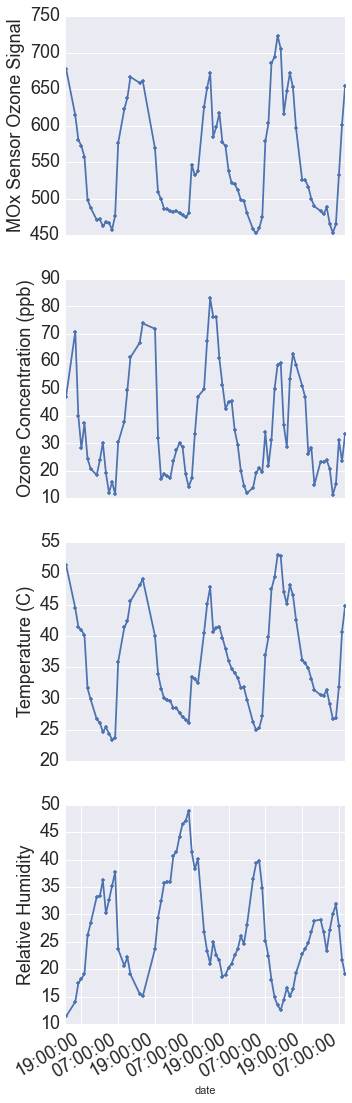

In [14]:
plot_03_temp_rh_no_scale(df_all, None, pod_number, ref_column, 'Training Data', cutoff_value, 5)

#### Plot the training ozone

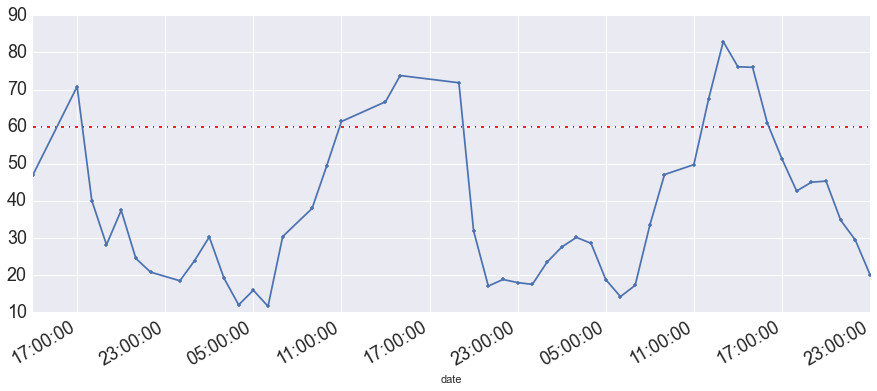

In [15]:
plot_tr_and_holdout(df_tr, None, pod_number, ref_column, 'Training Data', cutoff_value)

#### Plot holdout ozone to make sure that the holdout set has some high-value ozone measurements.

AttributeError: 'FigureCanvasAgg' object has no attribute 'invalidate'

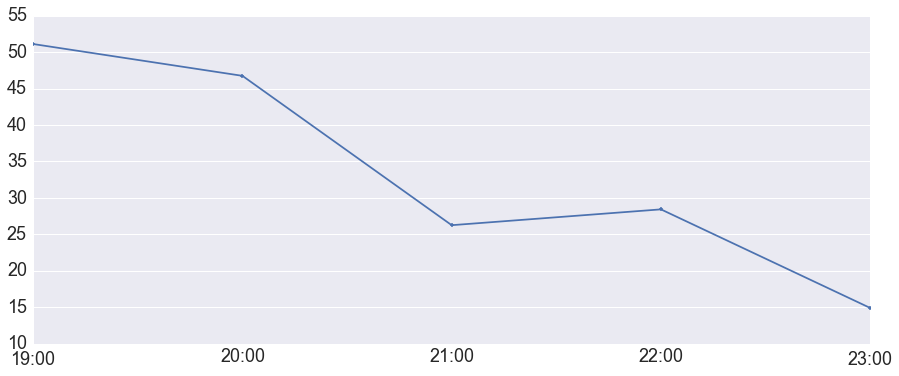

In [16]:
plot_tr_and_holdout(df_hold, None, pod_number, ref_column, 'Holdout Data', cutoff_value)

#### Declare a multiplication factor for the MSE part of the custom score function.

In [17]:
cust_mse_fact = 1

#### Linear Regression with Base Features

In [18]:
base_features = [pod_ozone,'Temp','Rh', 'no2']

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1283: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1349: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


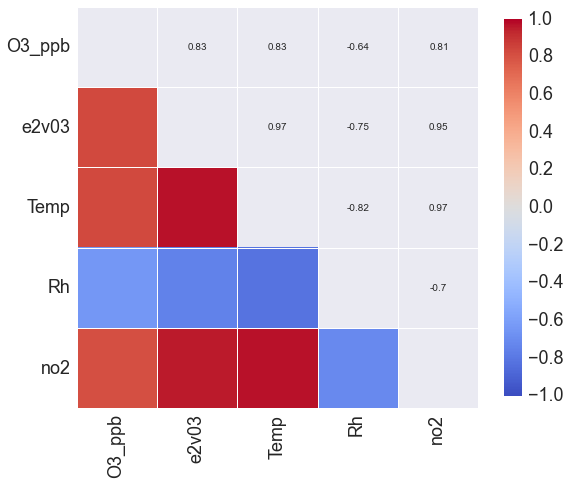

In [19]:
f, ax = plt.subplots(figsize=(9, 9))
sns.corrplot(df_tr[[ref_column] + base_features], annot=True, sig_stars=False,
             diag_names=False, ax=ax)

In [20]:
#Define the model.
lin_regr = linear_model.LinearRegression()
#find the MSE
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_base, y_cv, df_cv_lin_base, df_H_lin_base = cross_validation_by_day(lin_regr, base_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 10.2
Cross-Validation RMSE: 16.0 , High-Value CV RMSE: 16.0 , CV High Diff. in Mean (>60): -11.8
Holdout RMSE: 11.0 , High-Value Holdout RMSE: 12.0 , Holdout High Diff. in Mean.: -11.6


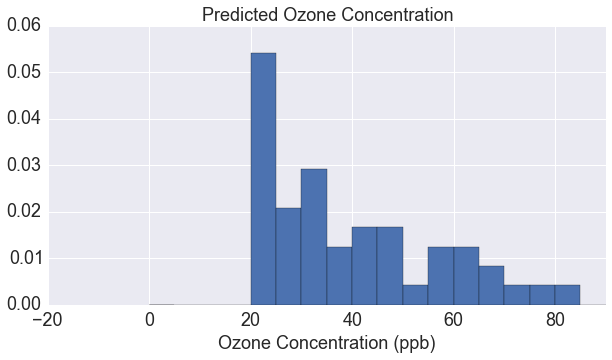

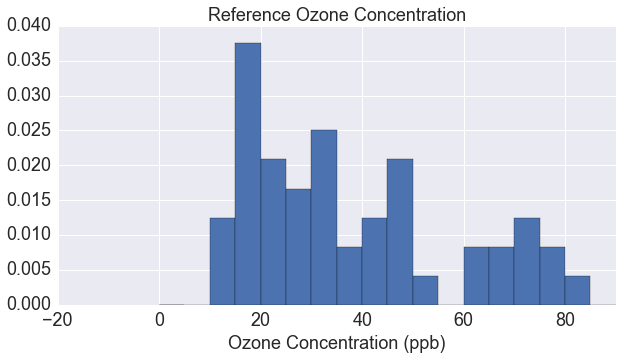

In [21]:
plot_hist(X_pred_cv_base, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_base, 'Reference Ozone Concentration')

#### Plot the learning curve for a linear regression with the base features.

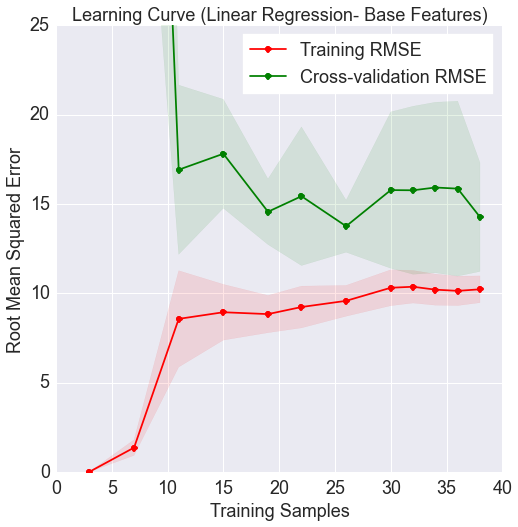

In [22]:
plt = plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- Base Features)", df_tr[base_features].values, df_tr[ref_column].values, (0,25), days_tr, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]))

The MSE is high for the cross-validation set in this plot, and the training and cross-validation scores come together in this plot tells us that we have resonably high bias. Create more features and add polynomial effects to reduce bias. 

#### Plot the residuals and comparison curves.

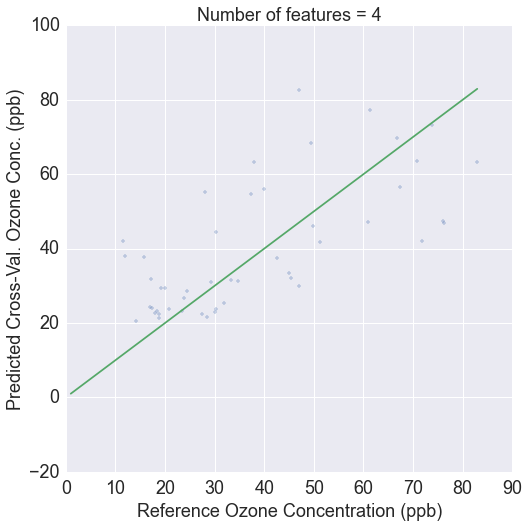

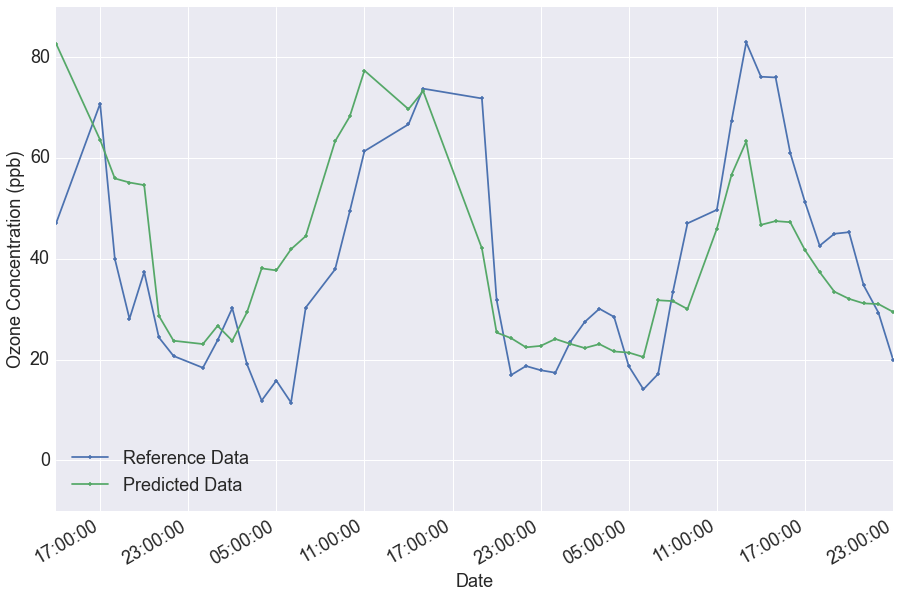

In [23]:
num_good_feat = len(base_features)
fitted_vs_ref_plot(df_cv_lin_base, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 0, ref_column)

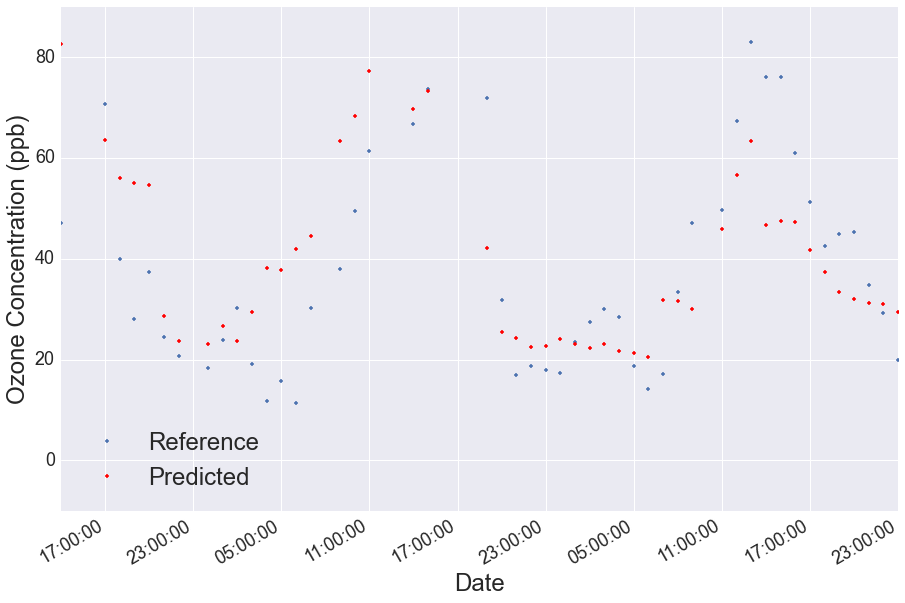

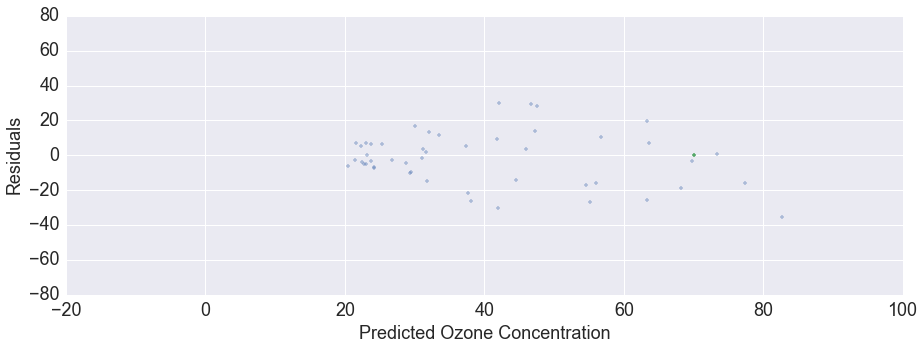

In [24]:
plot_fitted_and_ref_vs_time_no_lines(df_cv_lin_base, pod_number, 0, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_base, ref_column)

### Linear Regression with All Features.

In [25]:
every_feature = list(df_tr.ix[:,0:len(df_scaled.columns)])
leave_out = ['ref_o3_smooth', 'chunk', 'day', 'O3_ppb', 'UnixTime']
all_features = [f for f in every_feature if f not in leave_out]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_all, y_cv, df_cv_lin_all, df_H_lin_all = cross_validation_by_day(lin_regr, all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 0.0
Cross-Validation RMSE: 29.0 , High-Value CV RMSE: 31.0 , CV High Diff. in Mean (>60): 6.4
Holdout RMSE: 21.0 , High-Value Holdout RMSE: 21.0 , Holdout High Diff. in Mean.: -20.7


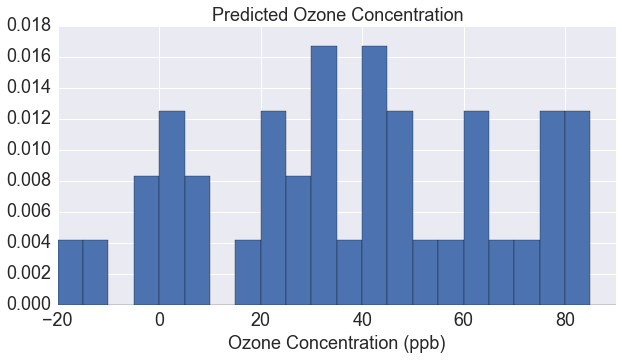

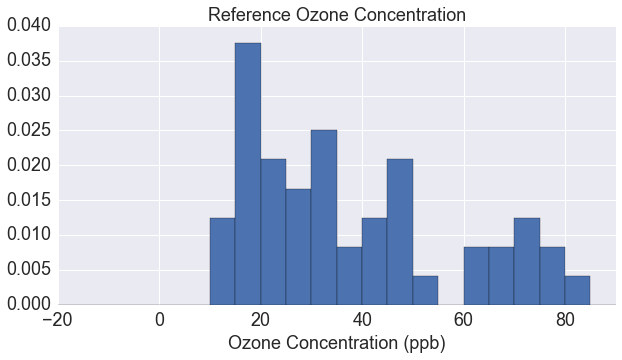

In [26]:
plot_hist(X_pred_cv_all, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_all, 'Reference Ozone Concentration')

#### Plot the residuals and comparison curves.

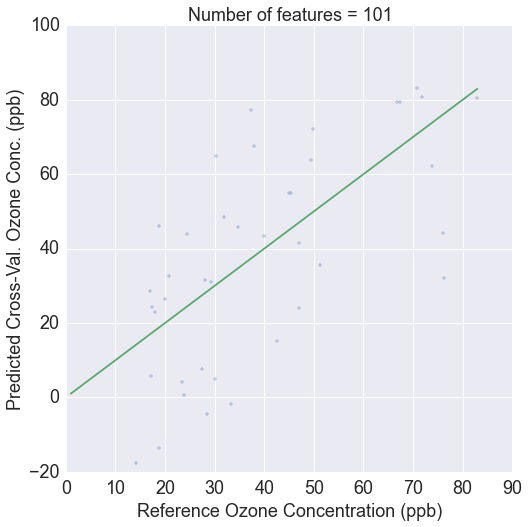

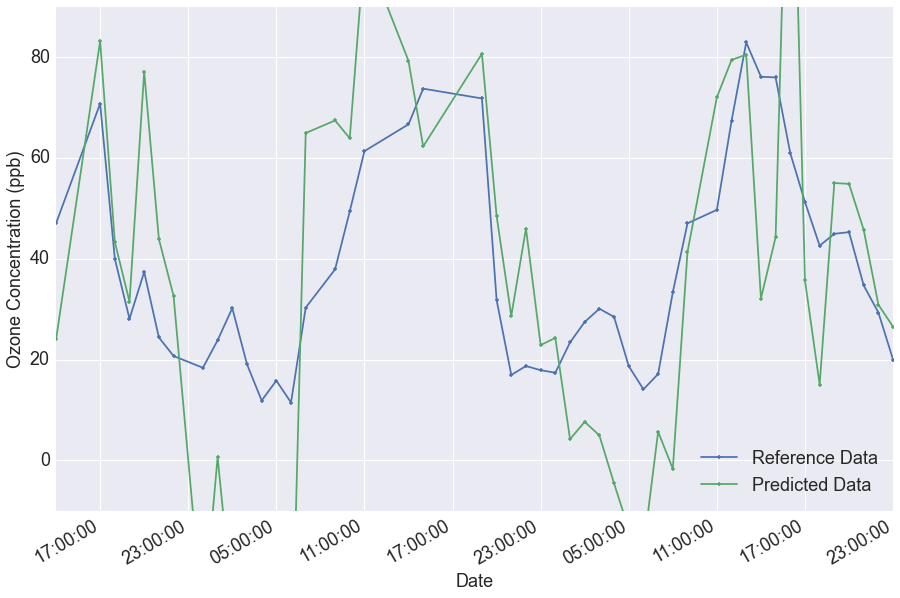

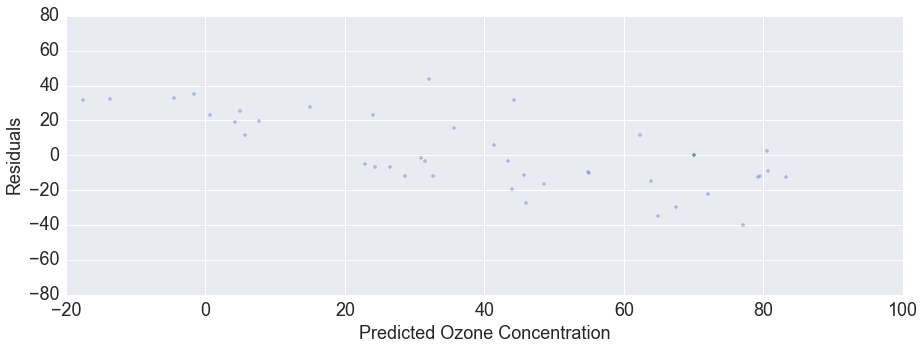

In [27]:
num_good_feat = len(all_features)
fitted_vs_ref_plot(df_cv_lin_all, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 0, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_all, ref_column)

## Forward Selection

#### Declare rather you want to use MSE or a custom error function:

In [28]:
#make a list of features from the column titles in the dataframe
features_all = list(df_tr.columns)
leave_out = ['Zenith Angle [degrees]','UnixTime', 'pod_o3_smooth', 'O3_ppb', 'ref_o3_smooth', ref_column, 'chunk']
features = [f for f in features_all if f not in leave_out]
features_it = [f for f in features if f not in 'day']
fs_features, score, RMSE = forward_selection_lodo(lin_regr, features_it, df_tr[[ref_column] + features].dropna(), 'custom_mse', ref_column, days_tr, 15, cust_mse_fact, cutoff_value)

Next best Feature:  Temp_int_lag_3 , Score:  15.0 RMSE:  62.1 #: 1
Next best Feature:  e2v03_interact_ln_rh , Score:  14.3 RMSE:  46.4 #: 2
Next best Feature:  Temp_interact_ln_rh , Score:  13.9 RMSE:  43.3 #: 3
Next best Feature:  ln_temp , Score:  13.5 RMSE:  48.8 #: 4
Next best Feature:  Temp_sq , Score:  12.3 RMSE:  54.5 #: 5
Next best Feature:  ln_O3_slope_lag_5 , Score:  11.4 RMSE:  24.5 #: 6
Next best Feature:  ln_O3_slope_lead_3 , Score:  11.3 RMSE:  20.9 #: 7
Next best Feature:  ln_O3_slope_lead_5 , Score:  11.2 RMSE:  19.4 #: 8
Next best Feature:  e2v03_int_lag_1 , Score:  11.2 RMSE:  19.4 #: 9
Next best Feature:  e2v03_int_lead_1 , Score:  11.2 RMSE:  19.4 #: 10
Next best Feature:  ln_O3_int_lag_1 , Score:  11.2 RMSE:  19.4 #: 11
Next best Feature:  ln_O3_int_lead_1 , Score:  11.2 RMSE:  19.4 #: 12
Next best Feature:  Temp_int_lag_1 , Score:  11.2 RMSE:  19.4 #: 13
Next best Feature:  Temp_int_lead_1 , Score:  11.2 RMSE:  19.4 #: 14
Next best Feature:  ln_temp_int_lag_1 , Sc

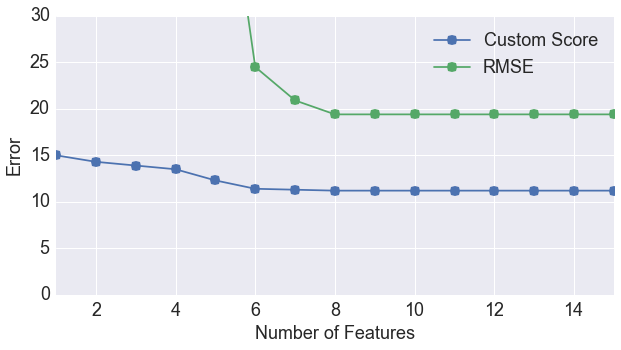

In [29]:
plot_error_vs_features(score, RMSE, [0,30], [1,15])

#### Plot cross-validation fitted data versus reference data, and choose number of features.

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/sklearn/learning_curve.py:217: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than than the size of 'train_sizes' 9 instead of 10).
  % (train_sizes_abs.shape[0], n_ticks), RuntimeWarning)


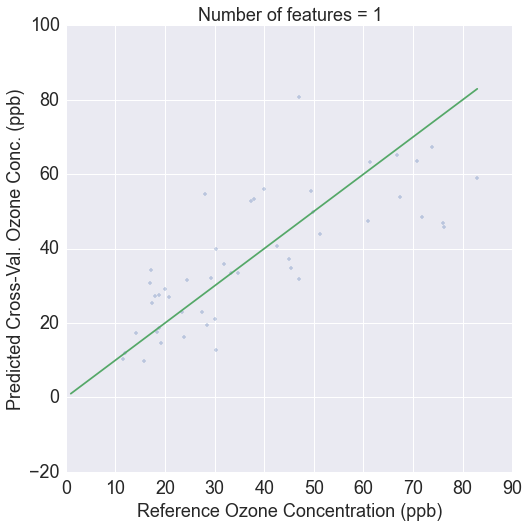

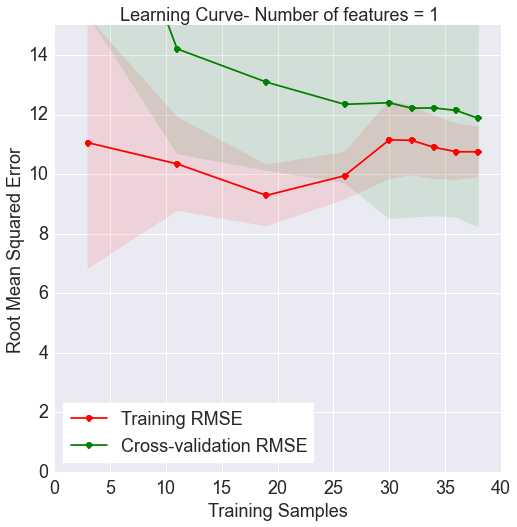

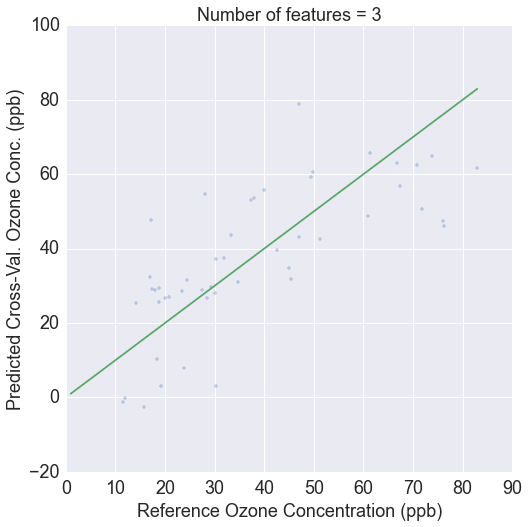

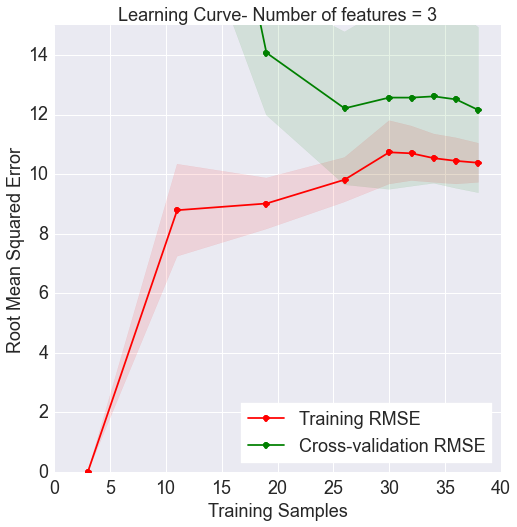

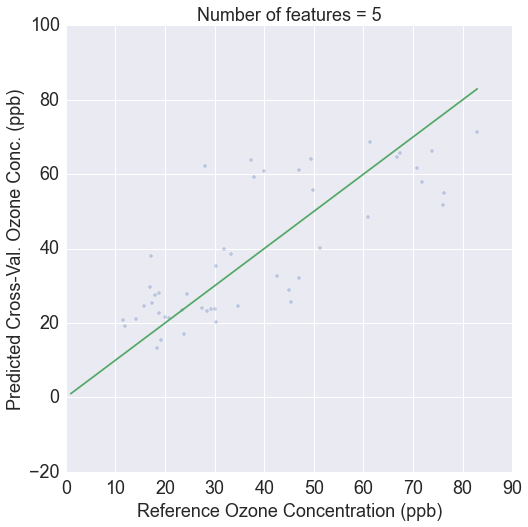

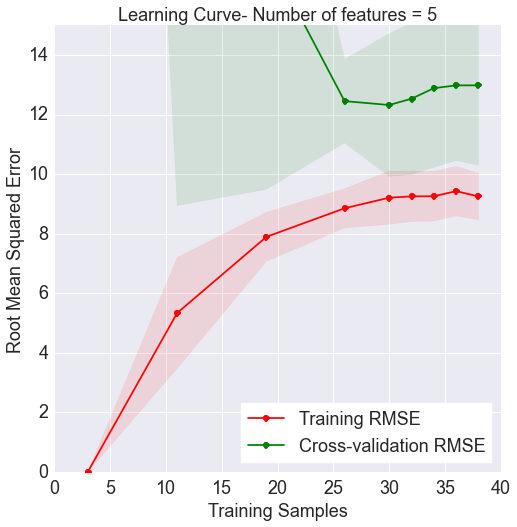

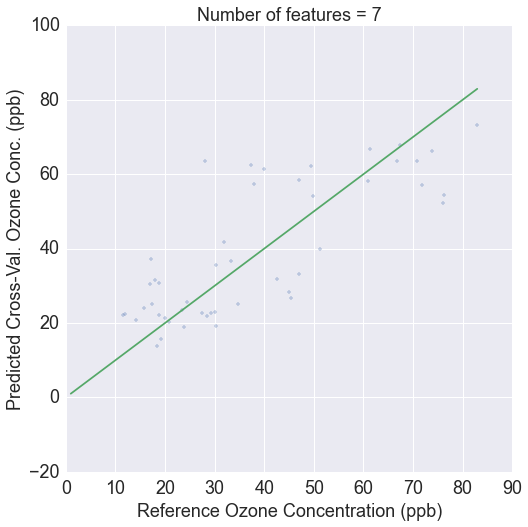

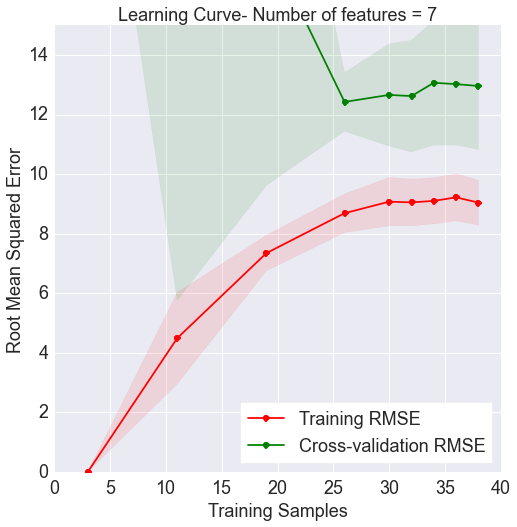

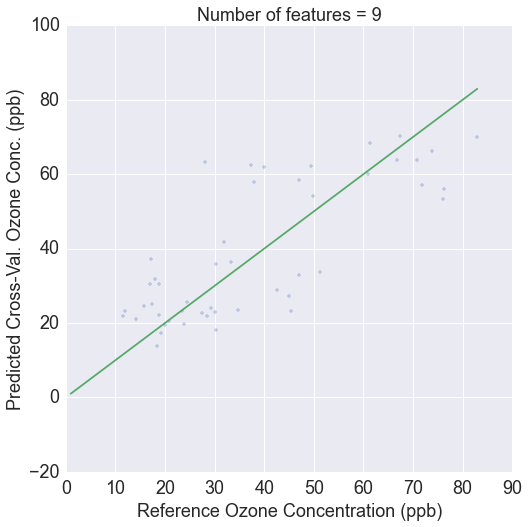

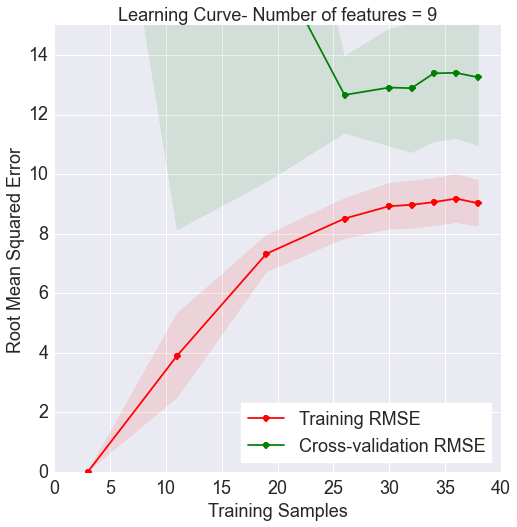

In [30]:
i = 1
while i < 10:
    num_good_feat = i
    df_cv_1, df_H_1 = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
    fitted_vs_ref_plot(df_cv_1, i, ref_column) 
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,15), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 2

In [85]:
# fs_features = ['ln_O3_int_lag_5', 'rh_cu', 'ln_rh_int_lag_3', 'e2v03_slope_lag_5', 'Temp_slope_lag_3', 'Temp_slope_lag_4', 'rh_sq', 'ln_rh_int_lead_2', 'ln_temp_slope_lead_2', 'ln_temp', '03_mult_rh_&_temp', 'Rh_slope_lead_5', 'e2v03_int_lag_1', 'e2v03_int_lead_1', 'e2v03_slope_lag_1']

#### Enter the chosen number of features, and perform a linear regression.

In [37]:
num_good_feat = 6
best_features = fs_features[:num_good_feat]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_best, y_cv_best, df_cv_lin_best, df_H_lin_best = cross_validation_by_day(lin_regr, best_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 9.2
Cross-Validation RMSE: 14.0 , High-Value CV RMSE: 11.0 , CV High Diff. in Mean (>60): -9.0
Holdout RMSE: 9.0 , High-Value Holdout RMSE: 11.0 , Holdout High Diff. in Mean.: -10.7


#### Print Best Features

In [38]:
best_features

['Temp_int_lag_3',
 'e2v03_interact_ln_rh',
 'Temp_interact_ln_rh',
 'ln_temp',
 'Temp_sq',
 'ln_O3_slope_lag_5']

### Plot the cross-validation data and residuals below.

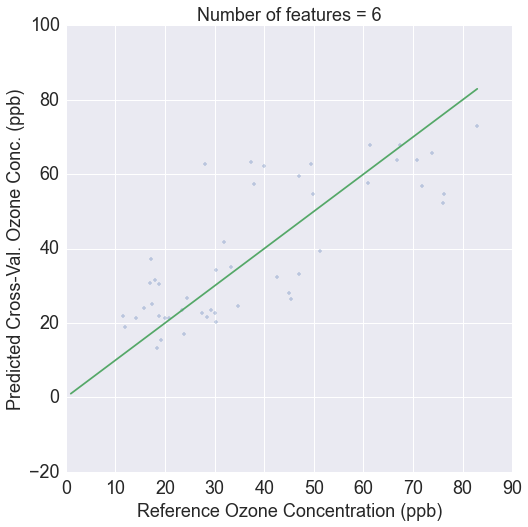

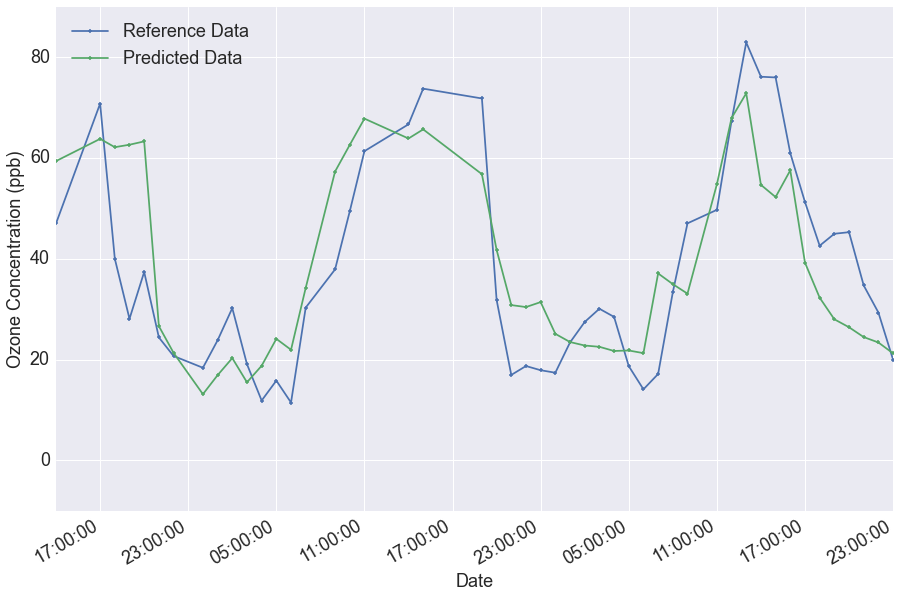

In [39]:
df_lin_regr_best_feat_cv, df_lin_regr_best_feat_H  = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat_cv, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 0, ref_column)

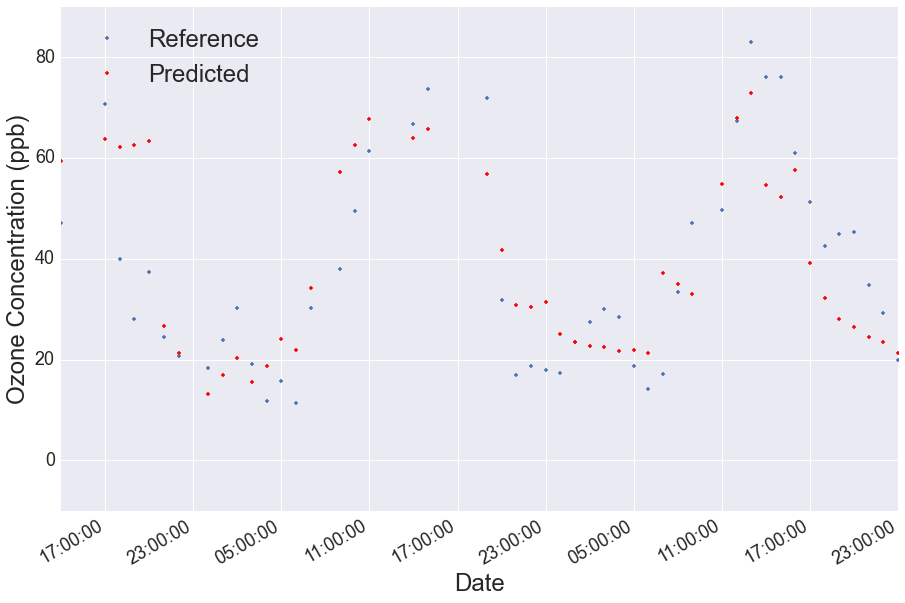

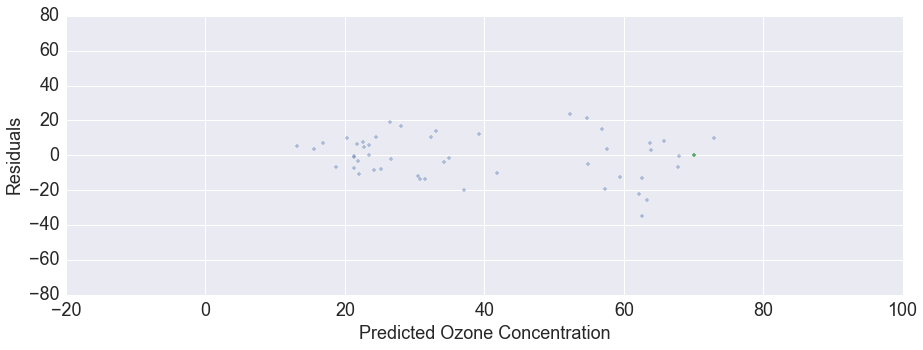

In [40]:
plot_fitted_and_ref_vs_time_no_lines(df_lin_regr_best_feat_cv, pod_number, 0, ref_column)
resid = plot_resid_vs_conc(df_lin_regr_best_feat_cv, ref_column)

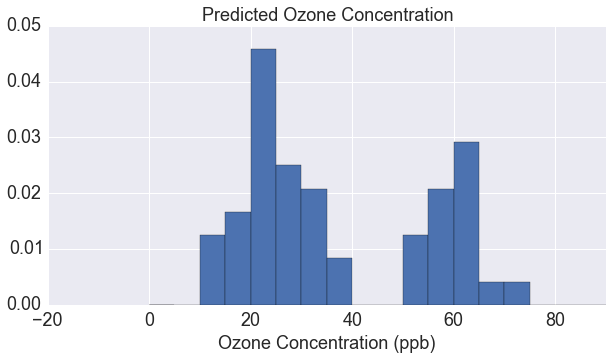

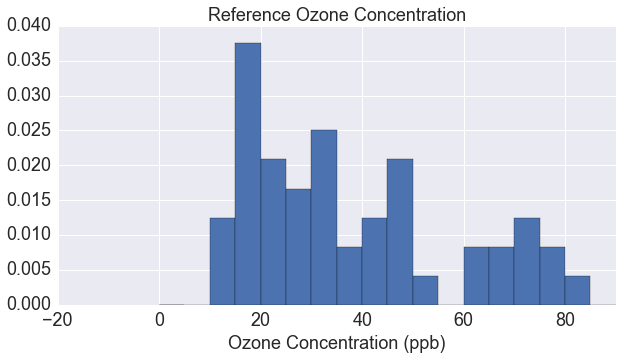

In [41]:
plot_hist(X_pred_cv_best, y_cv_best, 'Predicted Ozone Concentration')
plot_hist(y_cv_best, X_pred_cv_best, 'Reference Ozone Concentration')

### Prepare Data to Export

In [42]:
X = df_tr[best_features].values
y = df_tr[ref_column].values
lin = lin_regr.fit(X,y)
X_f = df_scaled[best_features].values
y_f = df_scaled[ref_column].values
pred = lin.predict(X_f)
df_pred = pd.DataFrame({'O3_fit':pred, 'O3_ppb': y_f}, index=df_scaled.index)

In [43]:
df_pred.head()

,O3_fit,O3_ppb
date,,
2014-07-21 14:00:00,56.028122,47.055
2014-07-21 17:00:00,57.342840,70.817
2014-07-21 18:00:00,54.744768,40.036
2014-07-21 19:00:00,54.298983,28.114
2014-07-21 20:00:00,53.563704,37.407


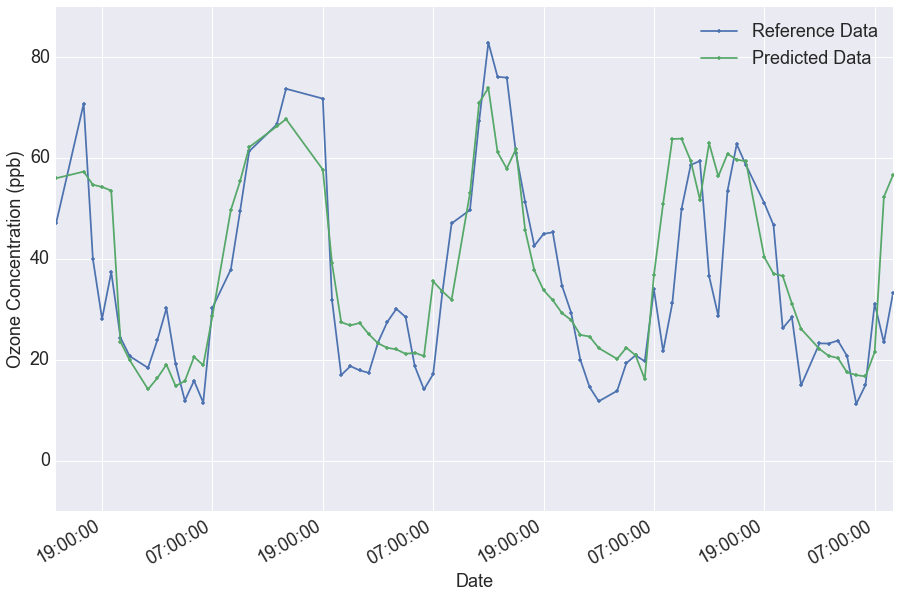

In [44]:
plot_fitted_and_ref_vs_time(df_pred, pod_number, 0, ref_column)

In [46]:
df_pred.to_csv("data/open_conc_coll_cham1.csv")

## Ridge Regression- All Features

In [248]:
fs_features = all_features
num_good_feat_ridge = len(all_features)

In [249]:
#define the training data
df_fits = df_tr[fs_features[:num_good_feat_ridge] + [ref_column] + ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat_ridge]].values
y = df_scaled[ref_column].values

#### Find the best lambda value using cross-validation

In [250]:
best_lambda_ridge, lambda_ridge, coefs, mean_score_lambda = find_best_lambda(Ridge, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.0000001, 1000000, 3, cust_mse_fact, cutoff_value)

lambda: 1e-07
score: 108.26
lambda: 3e-07
score: 107.83
lambda: 9e-07
score: 106.59
lambda: 2.7e-06
score: 103.14
lambda: 8.1e-06
score: 94.85
lambda: 2.43e-05
score: 80.14
lambda: 7.29e-05
score: 64.12
lambda: 0.0002187
score: 53.56
lambda: 0.0006561
score: 47.76
lambda: 0.0019683
score: 42.71
lambda: 0.0059049
score: 36.63
lambda: 0.0177147
score: 30.38
lambda: 0.0531441
score: 24.81
lambda: 0.1594323
score: 20.76
lambda: 0.4782969
score: 18.81
lambda: 1.4348907
score: 18.56
lambda: 4.3046721
score: 19.13
lambda: 12.9140163
score: 19.92
lambda: 38.7420489
score: 20.64
lambda: 116.2261467
score: 21.41
lambda: 348.6784401
score: 22.84
lambda: 1046.0353203
score: 25.42
lambda: 3138.1059609
score: 28.56
lambda: 9414.3178827
score: 30.83
lambda: 28242.9536481
score: 31.92
lambda: 84728.8609443
score: 32.34
lambda: 254186.582833
score: 32.49
lambda: 762559.748499
score: 32.53
Best Lambda: 1.4348907


#### Plot the values of lambda versus the coefficients and the custom score. 

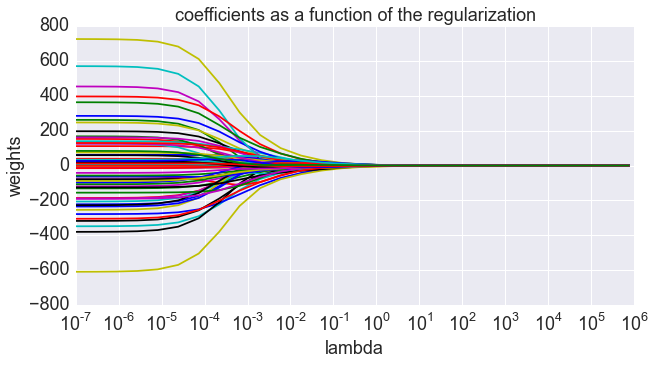

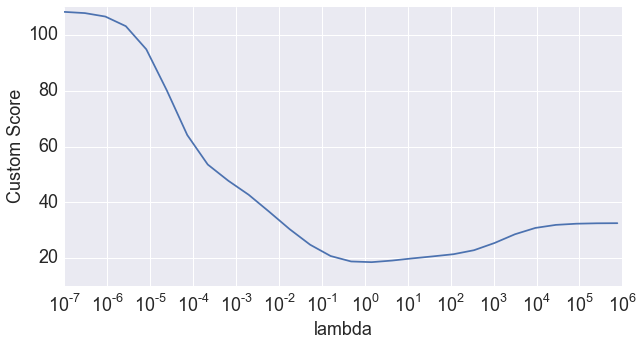

In [251]:
plot_lambda(lambda_ridge, coefs, mean_score_lambda)

#### Use the best lambda value found above to find errors.

In [252]:
MSE_CV_ridge, MSE_T_ridge, MSE_H_ridge, high_MSE_cv_ridge, X_pred_cv_ridge, y_cv_ridge, df_cv_ridge, df_H_ridge = cross_validation_by_day(Ridge(alpha = best_lambda_ridge), all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 9.1
Cross-Validation RMSE: 13.0 , High-Value CV RMSE: 19.0 , CV High Diff. in Mean (>50): -16.8
Holdout RMSE: 9.0 , High-Value Holdout RMSE: nan , Holdout High Diff. in Mean.: nan


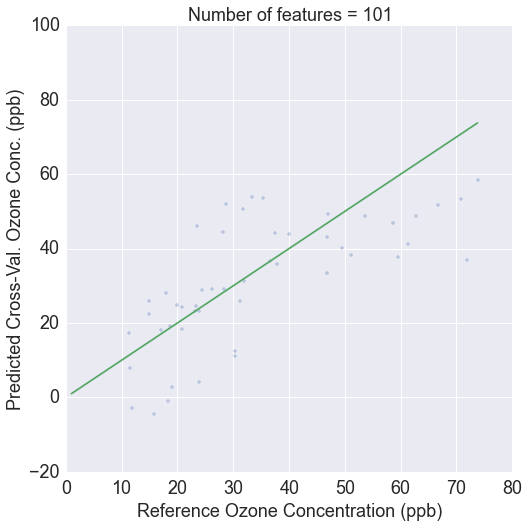

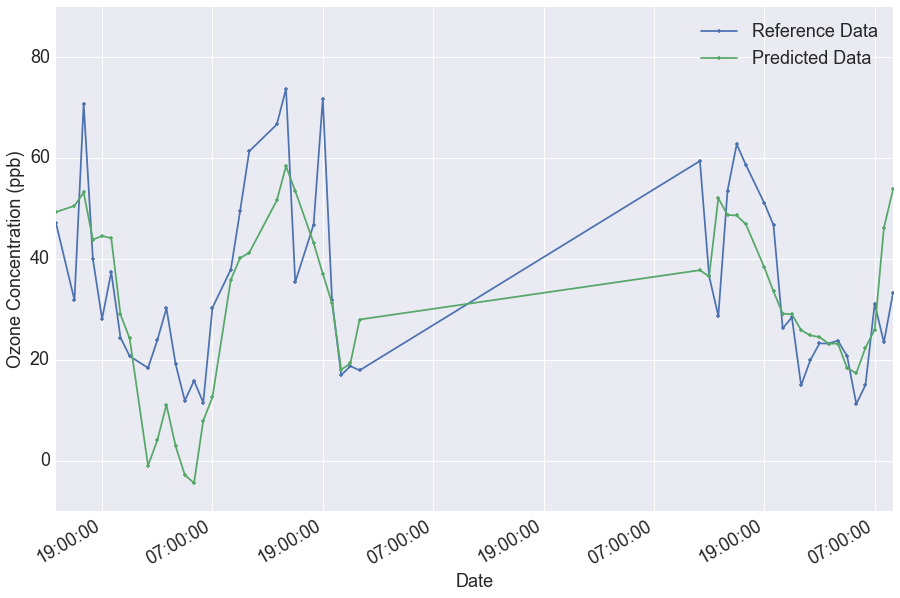

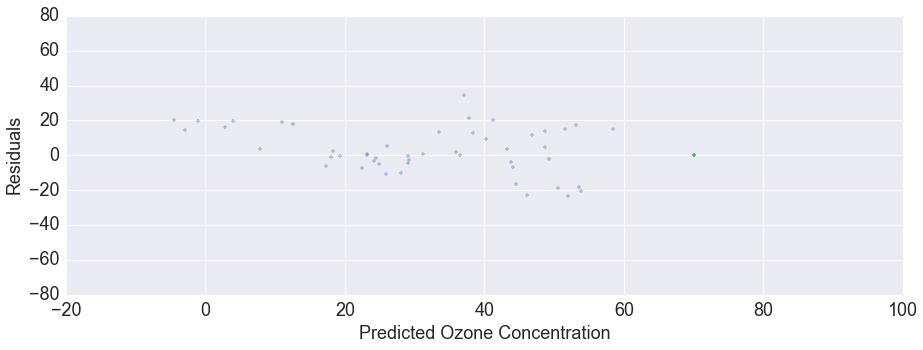

In [253]:
fitted_vs_ref_plot(df_cv_ridge, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 0, ref_column)
resid = plot_resid_vs_conc(df_cv_ridge, ref_column)

## Lasso

In [254]:
best_lambda_lasso, lambda_lasso, coefs_lasso, mean_score_lambda_lasso = find_best_lambda(Lasso, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.000001, 100, 3, cust_mse_fact, cutoff_value)

lambda: 1e-06
score: 32.7
lambda: 3e-06
score: 32.7
lambda: 9e-06
score: 32.69
lambda: 2.7e-05
score: 32.68
lambda: 8.1e-05
score: 32.65
lambda: 0.000243
score: 32.54
lambda: 0.000729
score: 32.2
lambda: 0.002187
score: 31.15
lambda: 0.006561
score: 27.99
lambda: 0.019683
score: 21.29
lambda: 0.059049
score: 18.69
lambda: 0.177147
score: 18.52
lambda: 0.531441
score: 20.32
lambda: 1.594323
score: 22.62
lambda: 4.782969
score: 25.44
lambda: 14.348907
score: 32.53
lambda: 43.046721
score: 32.56
Best Lambda: 0.177147


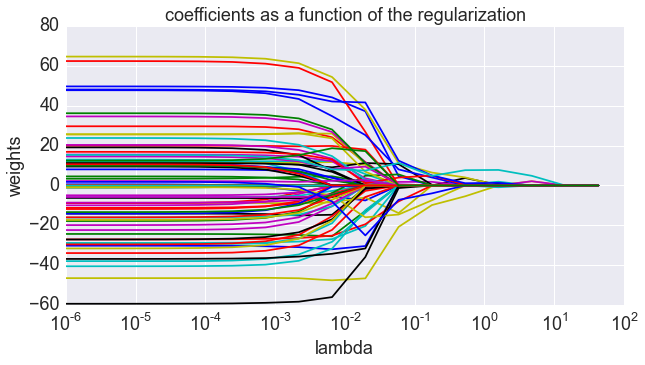

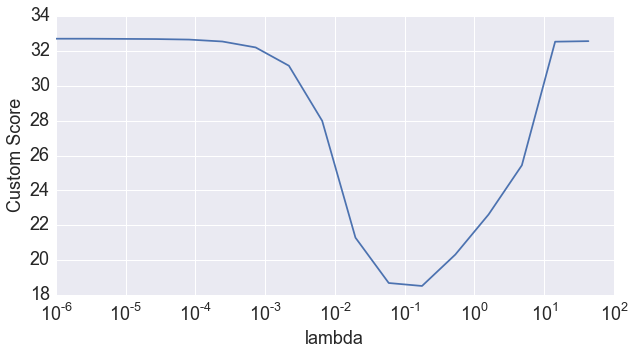

In [255]:
plot_lambda(lambda_lasso, coefs_lasso, mean_score_lambda_lasso)

#### Use the best lambda value found above to find holdout values.

In [256]:
MSE_CV_lasso, MSE_T_lasso, MSE_H_lasso, high_MSE_cv_lasso, X_pred_cv_lasso, y_cv_lasso, df_cv_lasso, df_H_lasso = cross_validation_by_day(Lasso(alpha = best_lambda_lasso), all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 9.3
Cross-Validation RMSE: 13.0 , High-Value CV RMSE: 18.0 , CV High Diff. in Mean (>50): -17.2
Holdout RMSE: 9.0 , High-Value Holdout RMSE: nan , Holdout High Diff. in Mean.: nan


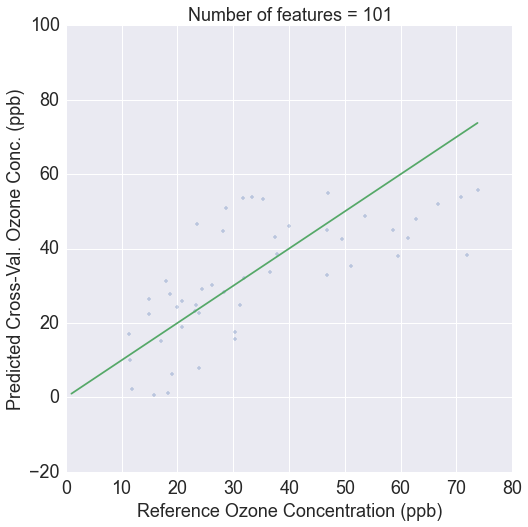

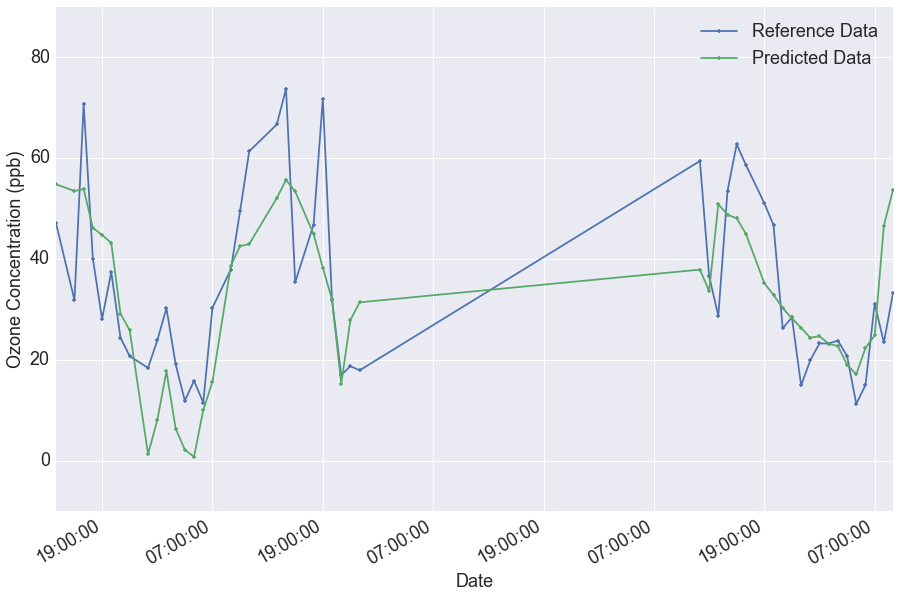

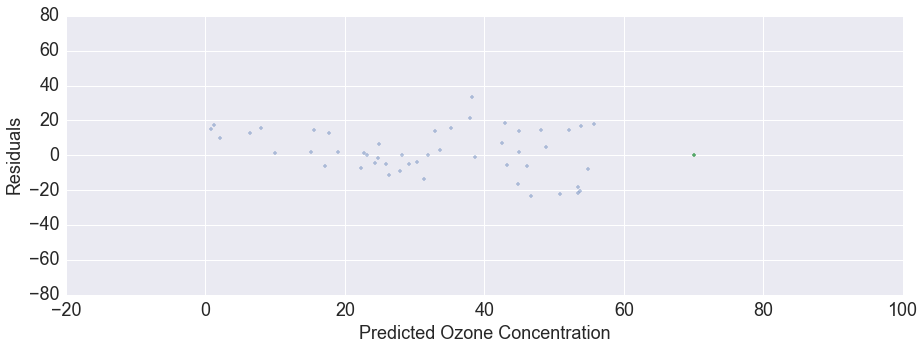

In [257]:
fitted_vs_ref_plot(df_cv_lasso, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 0, ref_column)
resid = plot_resid_vs_conc(df_cv_lasso, ref_column)

## Random Forest- All

In [258]:
MSE_CV, df_fit_rf = find_MSE_random_forest(df_fits, fs_features[:num_good_feat], days_tr, 0, ref_column)

7-21 Cross-Validation RMSE:  16.6
7-22 Cross-Validation RMSE:  15.6
7-24 Cross-Validation RMSE:  14.9
7-25 Cross-Validation RMSE:  11.0
Overall RMSE: 14.5408701887


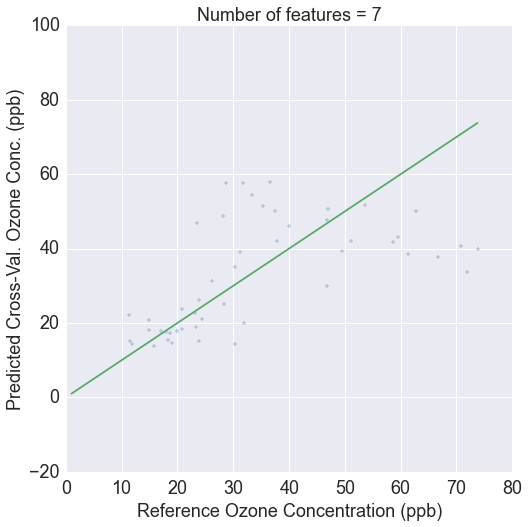

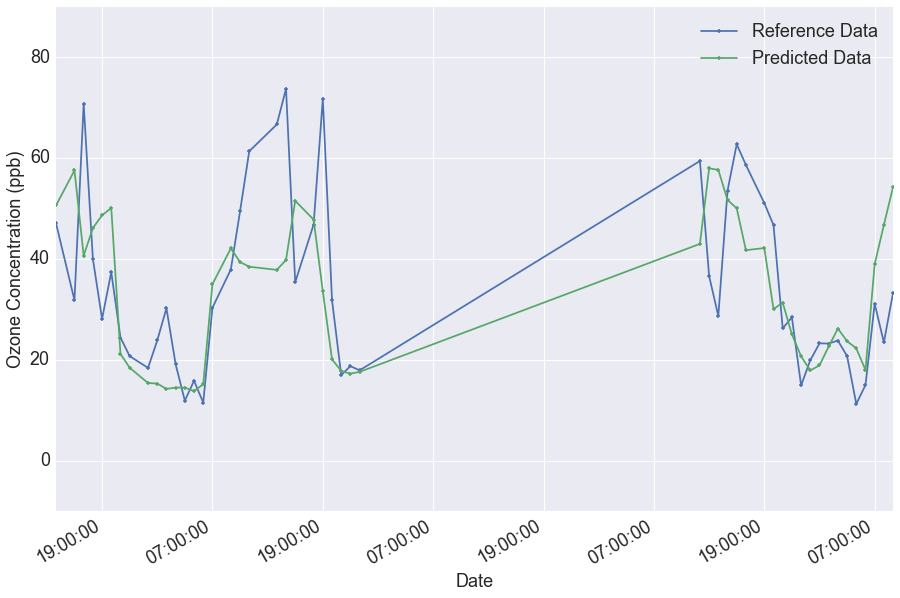

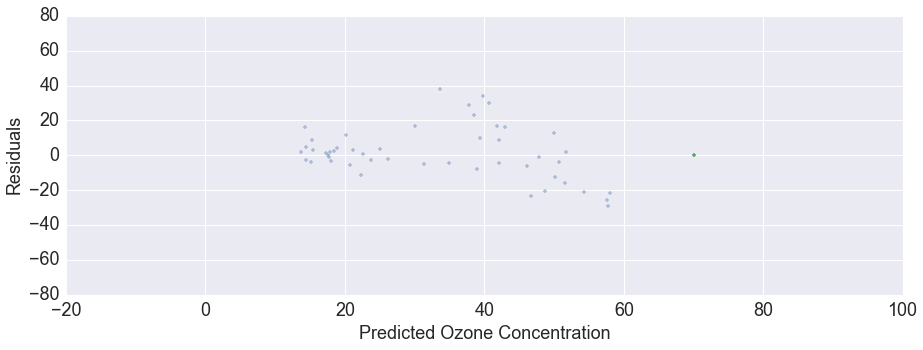

In [259]:
fitted_vs_ref_plot(df_fit_rf, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 0, ref_column)
resid = plot_resid_vs_conc(df_fit_rf, ref_column)

## Random Forest- Base

In [260]:
MSE_CV_base, df_fit_rf_base = find_MSE_random_forest(df_fits, base_features, days_tr, 0, ref_column)

7-21 Cross-Validation RMSE:  16.1
7-22 Cross-Validation RMSE:  15.0
7-24 Cross-Validation RMSE:  15.3
7-25 Cross-Validation RMSE:  11.1
Overall RMSE: 14.3543131083


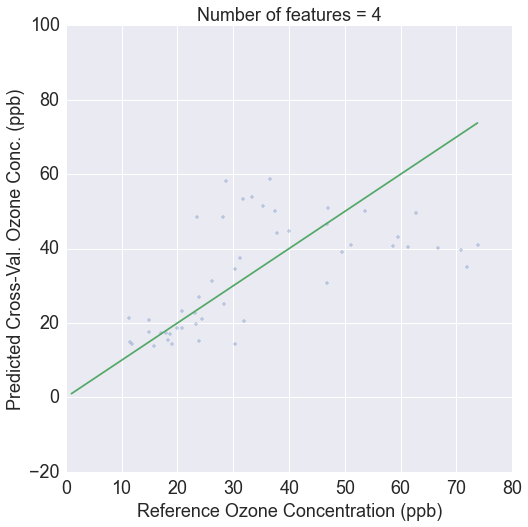

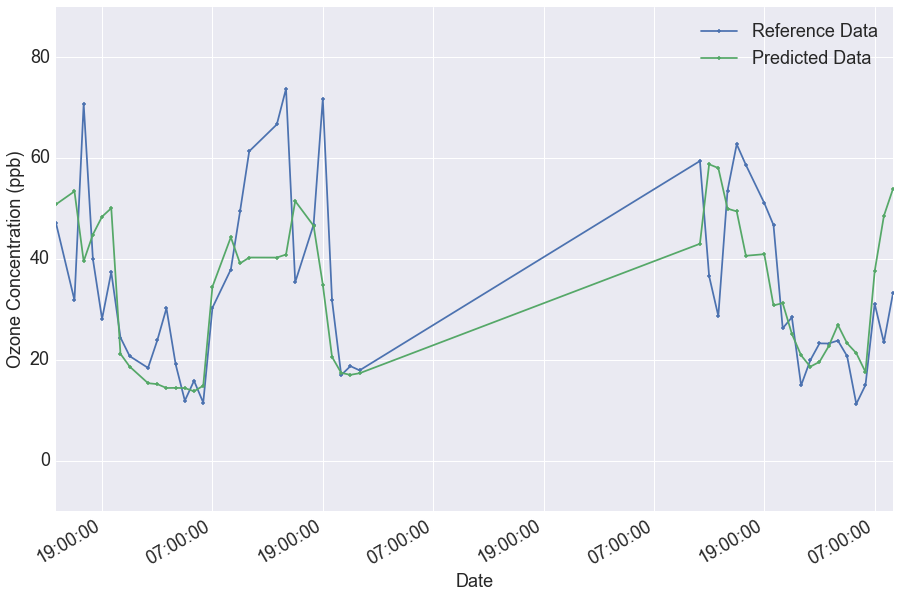

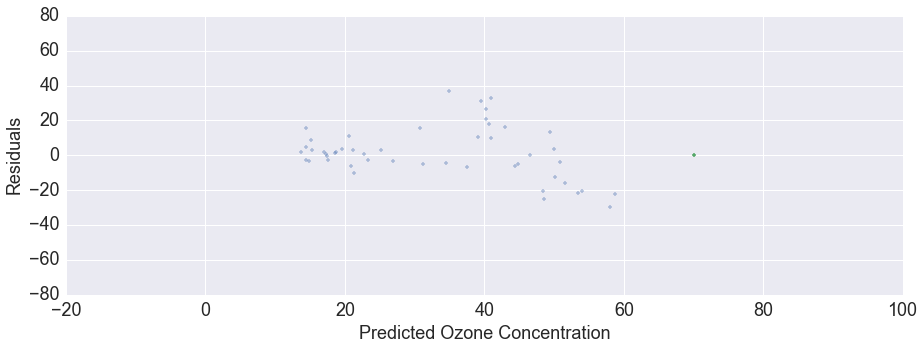

In [261]:
fitted_vs_ref_plot(df_fit_rf_base, 4, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 0, ref_column)
resid = plot_resid_vs_conc(df_fit_rf_base, ref_column)